In [6]:
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

In [7]:
def match_features(des1, des2, kp1, kp2):
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])
    
    matches = []
    for pair in good:
        matches.append(list(kp1[pair[0].queryIdx].pt + kp2[pair[0].trainIdx].pt))

    matches = np.array(matches)
    return matches

def plot_matches(matches, total_img):
    match_img = total_img.copy()
    offset = total_img.shape[1]/2
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(np.array(match_img).astype('uint8')) #　RGB is integer type
    
    ax.plot(matches[:, 0], matches[:, 1], 'xr')
    ax.plot(matches[:, 2] + offset, matches[:, 3], 'xr')
     
    ax.plot([matches[:, 0], matches[:, 2] + offset], [matches[:, 1], matches[:, 3]],
            'r', linewidth=0.5)

    plt.show()
def homography(pairs):
    A = []
    for pair in pairs:
        x1, y1, x2, y2 = pair
        A.append([x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1, -y2])
    A = np.array(A)
    U, S, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)
    H = H / H[2, 2]
    return H

def random_point(matches, k=4):
    idx = random.sample(range(len(matches)), k)
    point = [matches[i] for i in idx ]
    return np.array(point)

def get_error(points, H):
    num_points = len(points)
    all_p1 = np.concatenate((points[:, 0:2], np.ones((num_points, 1))), axis=1)
    all_p2 = points[:, 2:4]
    estimate_p2 = np.zeros((num_points, 2))
    for i in range(num_points):
        temp = np.dot(H, all_p1[i])
        estimate_p2[i] = (temp/temp[2])[0:2] # set index 2 to 1 and slice the index 0, 1
    # Compute error
    errors = np.linalg.norm(all_p2 - estimate_p2 , axis=1) ** 2

    return errors

def ransac(matches, threshold, iters):
    num_best_inliers = 0
    
    for i in range(iters):
        points = random_point(matches)
        H = homography(points)
        
        #  avoid dividing by zero 
        if np.linalg.matrix_rank(H) < 3:
            continue
            
        errors = get_error(matches, H)
        idx = np.where(errors < threshold)[0]
        inliers = matches[idx]

        num_inliers = len(inliers)
        if num_inliers > num_best_inliers:
            best_inliers = inliers.copy()
            num_best_inliers = num_inliers
            best_H = H.copy()
            
    print("inliers/matches: {}/{}".format(num_best_inliers, len(matches)))
    return best_inliers, best_H

def plot_two(img_left, img_right):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img_left, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(img_right, cmap='gray')
    plt.show()


def stitch_img(left, right, H):
    print("stiching image ...")
    
    # Convert to double and normalize. Avoid noise.
    left = cv.normalize(left.astype('float'), None, 
                            0.0, 1.0, cv.NORM_MINMAX)   
    # Convert to double and normalize.
    right = cv.normalize(right.astype('float'), None, 
                            0.0, 1.0, cv.NORM_MINMAX)   
    
    # left image
    height_l, width_l, channel_l = left.shape
    corners = [[0, 0, 1], [width_l, 0, 1], [width_l, height_l, 1], [0, height_l, 1]]
    corners_new = [np.dot(H, corner) for corner in corners]
    corners_new = np.array(corners_new).T 
    x_news = corners_new[0] / corners_new[2]
    y_news = corners_new[1] / corners_new[2]
    y_min = min(y_news)
    x_min = min(x_news)

    translation_mat = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    H = np.dot(translation_mat, H)
    
    # Get height, width
    height_new = int(round(abs(y_min) + height_l))
    width_new = int(round(abs(x_min) + width_l))
    size = (width_new, height_new)

    # right image
    warped_l = cv.warpPerspective(src=left, M=H, dsize=size)

    height_r, width_r, channel_r = right.shape
    
    height_new = int(round(abs(y_min) + height_r))
    width_new = int(round(abs(x_min) + width_r))
    size = (width_new, height_new)
    

    warped_r = cv.warpPerspective(src=right, M=translation_mat, dsize=size)
    plot_two(warped_l, warped_r)
    black = np.zeros(3)  # Black pixel.

    for i in range(warped_r.shape[0]):
        for j in range(warped_r.shape[1]):
            pixel_l = warped_l[i, j, :]
            pixel_r = warped_r[i, j, :]
            
            if not np.array_equal(pixel_l, black) and np.array_equal(pixel_r, black):
                warped_l[i, j, :] = pixel_l
            elif np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
                warped_l[i, j, :] = pixel_r
            elif not np.array_equal(pixel_l, black) and not np.array_equal(pixel_r, black):
                warped_l[i, j, :] = (pixel_l + pixel_r) / 2
            else:
                pass
                  
    stitch_image = warped_l[:warped_r.shape[0], :warped_r.shape[1], :]

    return stitch_image

    
def plot_two(img_left, img_right):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img_left, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(img_right, cmap='gray')
    plt.show()


In [9]:
building1 = cv.imread('gsu_buildings/rialto_team6-1.png')
building2 = cv.imread('gsu_buildings/rialto_team6-2.png')

left = cv.cvtColor(building1, cv.COLOR_BGR2RGB)
right = cv.cvtColor(building2, cv.COLOR_BGR2RGB)

left_gray = cv.cvtColor(building1, cv.COLOR_BGR2GRAY)
right_gray = cv.cvtColor(building2, cv.COLOR_BGR2GRAY)

keypoints: 500, descriptors: (500, 32)


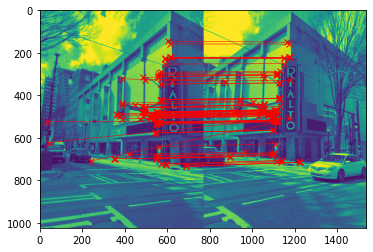

In [10]:
orb = cv.ORB_create()

kp1, des1 = orb.detectAndCompute(left_gray, None)
kp2, des2 = orb.detectAndCompute(right_gray, None)

print("keypoints: {}, descriptors: {}".format(len(kp1), des1.shape))
matches = match_features(des1, des2, kp1, kp2)

total_img = np.concatenate((left_gray, right_gray), axis=1)
plot_matches(matches, total_img) # Good mathces
  

inliers/matches: 23/89
H: [[ 1.23111808e+00 -2.20088254e-02 -2.64098519e+02]
 [ 1.93488146e-01  1.19396528e+00 -1.18272134e+02]
 [ 3.08821546e-04  4.62748130e-05  1.00000000e+00]]
stiching image ...


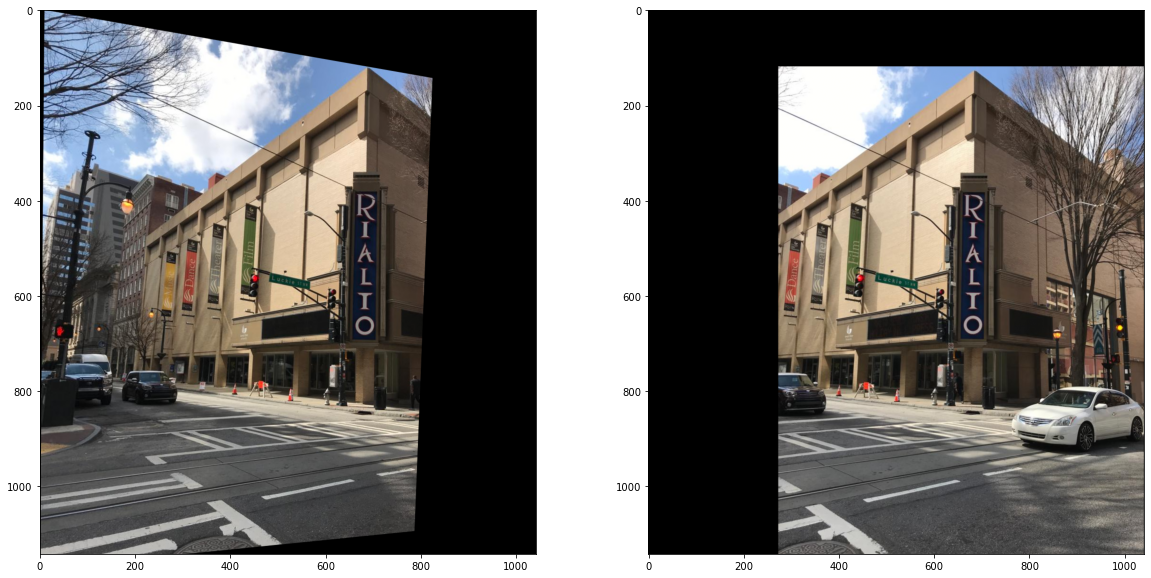

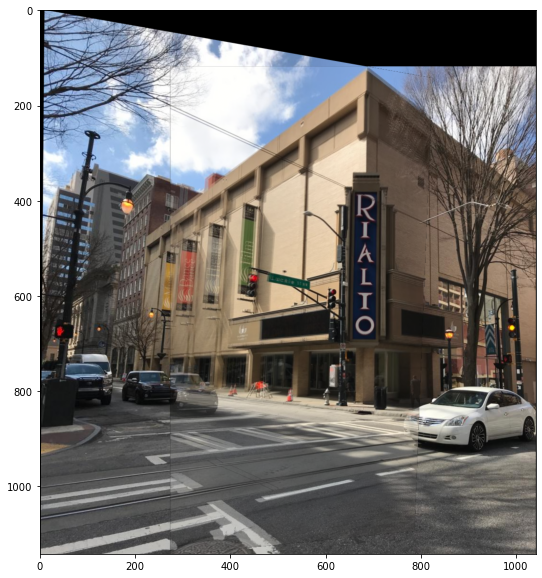

In [11]:
inliner, H = ransac(matches, 0.5, 1000)
print("H: {}".format(H))

img = stitch_img(left, right, H)

plt.figure(figsize=(20,10))
plt.imshow(img)